In [1]:
import zipfile
import pandas as pd
import numpy as np
import networkx as nx

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.transforms import RandomNodeSplit
from torch_geometric.nn import GCNConv

import matplotlib.pyplot as plt

In [2]:
edge_df=pd.read_csv("../data/raw/large_twitch_edges.csv")
feature_df=pd.read_csv("../data/raw/large_twitch_features.csv")

In [3]:
edge_df.head()

,numeric_id_1,numeric_id_2
0,98343,141493
1,98343,58736
2,98343,140703
3,98343,151401
4,98343,157118


In [4]:
feature_df.head()

,views,mature,life_time,created_at,updated_at,numeric_id,dead_account,language,affiliate
0,7879,1,969,2016-02-16,2018-10-12,0,0,EN,1
1,500,0,2699,2011-05-19,2018-10-08,1,0,EN,0
2,382502,1,3149,2010-02-27,2018-10-12,2,0,EN,1
3,386,0,1344,2015-01-26,2018-10-01,3,0,EN,0
4,2486,0,1784,2013-11-22,2018-10-11,4,0,EN,0


In [5]:
feature_df.dtypes

views            int64
mature           int64
life_time        int64
created_at      object
updated_at      object
numeric_id       int64
dead_account     int64
language        object
affiliate        int64
dtype: object

In [6]:
G = nx.from_pandas_edgelist(edge_df, source = "numeric_id_1", target = "numeric_id_2")
print("Edges:", G.number_of_edges())
print("Nodes:", G.number_of_nodes())

Edges: 6797557
Nodes: 168114


In [7]:
feature_df_time = feature_df.copy()
feature_df_time[["created_at_year", "created_at_month", "created_at_day"]] = feature_df_time["created_at"].str.split('-', expand = True).astype(int)
feature_df_time[["updated_at_year", "updated_at_month", "updated_at_day"]] = feature_df_time["updated_at"].str.split('-', expand = True).astype(int)

In [8]:
feature_df_time.head(10)

,views,mature,life_time,created_at,updated_at,numeric_id,dead_account,language,affiliate,created_at_year,created_at_month,created_at_day,updated_at_year,updated_at_month,updated_at_day
0,7879,1,969,2016-02-16,2018-10-12,0,0,EN,1,2016,2,16,2018,10,12
1,500,0,2699,2011-05-19,2018-10-08,1,0,EN,0,2011,5,19,2018,10,8
2,382502,1,3149,2010-02-27,2018-10-12,2,0,EN,1,2010,2,27,2018,10,12
3,386,0,1344,2015-01-26,2018-10-01,3,0,EN,0,2015,1,26,2018,10,1
4,2486,0,1784,2013-11-22,2018-10-11,4,0,EN,0,2013,11,22,2018,10,11
5,4987,1,1288,2015-04-03,2018-10-12,5,0,EN,1,2015,4,3,2018,10,12
6,234,0,358,2017-09-14,2018-09-07,6,0,EN,0,2017,9,14,2018,9,7
7,775,1,577,2017-03-14,2018-10-12,7,0,FR,0,2017,3,14,2018,10,12
8,69020,0,1781,2013-11-22,2018-10-08,8,0,EN,0,2013,11,22,2018,10,8
9,32073,0,499,2017-05-31,2018-10-12,9,0,KO,1,2017,5,31,2018,10,12


In [9]:
def encode_data():
    OHE_features = []
    other_features = ["views", "mature", "life_time", "dead_account", "affiliate"]
    all_features = OHE_features + other_features

    OHE = OneHotEncoder()
    CT = ColumnTransformer([("one hot encoding", OHE, OHE_features)], remainder = "passthrough")

    feature_matrix = CT.fit_transform(feature_df_time[all_features])

    return feature_matrix

def construct_graph(feature_matrix):
    if type(feature_matrix) != np.ndarray:
        feature_matrix = feature_matrix.todense()
    node_features = torch.tensor(feature_matrix)

    LE = LabelEncoder()
    label_vector = LE.fit_transform(feature_df_time["language"])
    node_labels = torch.tensor(label_vector).long()
    
    edges_list = edge_df.values.tolist()
    edge_index1 = torch.tensor(edges_list, dtype = torch.long).T
    edge_index2 = torch.zeros(edge_index1.shape, dtype = torch.long)
    edge_index2[0,:] = edge_index1[1,:]
    edge_index2[1,:] = edge_index1[0,:]
    edge_index = torch.cat((edge_index1, edge_index2), axis = 1)
    g = Data(x = node_features, y = node_labels, edge_index = edge_index)

    return g

In [10]:
data_encoded = encode_data()
g = construct_graph(data_encoded)

In [11]:
split = RandomNodeSplit(split = "train_rest", num_splits = 1, num_val = 0.2, num_test = 0.1)
g = split(g)
print(g, "\n")
print("training samples", torch.sum(g.train_mask).item())
print("validation samples", torch.sum(g.val_mask).item())
print("test samples", torch.sum(g.test_mask).item())

Data(x=[168114, 5], edge_index=[2, 13595114], y=[168114], train_mask=[168114], val_mask=[168114], test_mask=[168114]) 

training samples 117680
validation samples 33623
test samples 16811


In [12]:
class SocialGNN(torch.nn.Module):
    def __init__(self, num_features, f):
        super(SocialGNN, self).__init__()

        self.conv1 = GCNConv(num_features, f)
        self.conv2 = GCNConv(f, 21)

    def forward(self, data):
        x = data.x.float()
        edge_index = data.edge_index

        x = self.conv1(x = x, edge_index = edge_index)
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        return x

In [13]:
criterion = torch.nn.CrossEntropyLoss()

def masked_loss(predictions, labels, mask):
    mask = mask.float()
    mask = mask / torch.mean(mask)
    loss = criterion(predictions, labels)
    loss = loss * mask
    loss = torch.mean(loss)
    return loss

def masked_accuracy(predictions, labels, mask):
    mask = mask.float()
    mask = mask / torch.mean(mask)
    accuracy = (torch.argmax(predictions, axis = 1) == labels).long()
    accuracy = mask * accuracy
    accuracy = torch.mean(accuracy)
    return accuracy

In [14]:
def train_social(net, data, epochs = 10, lr = 0.01):
    optimizer = torch.optim.Adam(net.parameters(), lr = lr)
    best_accuracy = 0.0

    train_losses = []
    train_accuracies = []

    val_losses = []
    val_accuracies = []

    test_losses = []
    test_accuracies = []

    for epoch in range(epochs + 1):
        optimizer.zero_grad()
        out = net(data)
        loss = masked_loss(predictions = out, labels = data.y, mask = data.train_mask)
        loss.backward()
        optimizer.step()

        train_losses += [loss.detach()]
        train_accuracy = masked_accuracy(predictions = out, labels = data.y, mask = data.train_mask)
        train_accuracies += [train_accuracy]

        val_loss = masked_loss(predictions = out, labels = data.y, mask = data.val_mask)
        val_losses += [val_loss.detach()]
        val_accuracy = masked_accuracy(predictions = out, labels = data.y, mask = data.val_mask)
        val_accuracies += [val_accuracy]

        test_loss = masked_loss(predictions = out, labels = data.y, mask = data.test_mask)
        test_losses += [test_loss.detach()]
        test_accuracy = masked_accuracy(predictions = out, labels = data.y, mask = data.test_mask)
        test_accuracies += [test_accuracy]

        if np.round(val_accuracy, 4) > np.round(best_accuracy, 4):
            print("Epoch {}/{}, Train Loss: {:.4f}, Train Accuracy: {:.4f}, Val Accuracy: {:.4f}, Test Accuracy: {:.4f}".format(epoch + 1, epochs, loss.item(), train_accuracy, val_accuracy, test_accuracy))
            best_accuracy = val_accuracy

    print(train_losses,type(train_losses))
    plt.plot(train_losses, label="train")  
    plt.plot(val_losses, label="validation")
    plt.plot(test_losses, label="test")  

    plt.show()
    
    plt.plot(train_accuracies, label="train") 
    plt.plot(val_accuracies, label="validation")
    plt.plot(test_accuracies, label="test") 
    plt.show()

Epoch 1/50, Train Loss: 161018.9844, Train Accuracy: 0.0341, Val Accuracy: 0.0330, Test Accuracy: 0.0339
[tensor(161018.9844), tensor(159551.9062), tensor(158086.7500), tensor(156622.8281), tensor(155159.8125), tensor(153808.4844), tensor(152745.9844), tensor(151585.3750), tensor(150363.6562), tensor(149243.0625), tensor(148310.5312), tensor(147261.5938), tensor(146133.0625), tensor(144966.4688), tensor(143901.5312), tensor(142852.4219), tensor(141796.8125), tensor(140781.7031), tensor(139694.3594), tensor(138575.8281), tensor(137495.4844), tensor(136397.4844), tensor(135316.1094), tensor(134257.7969), tensor(133184.2188), tensor(132100.2188), tensor(130994.2188), tensor(129872.7812), tensor(128808.4688), tensor(127721.3594), tensor(126601.0781), tensor(125510.3203), tensor(124409.3203), tensor(123293.0391), tensor(122205.1641), tensor(121094.2578), tensor(119978.5625), tensor(118878.3047), tensor(117760.6719), tensor(116656.7031), tensor(115533.9844), tensor(114603.8672), tensor(11356

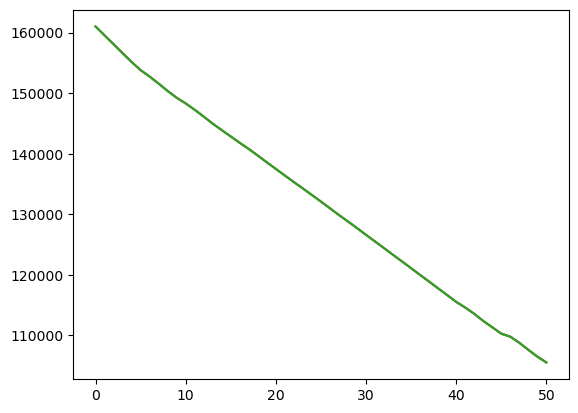

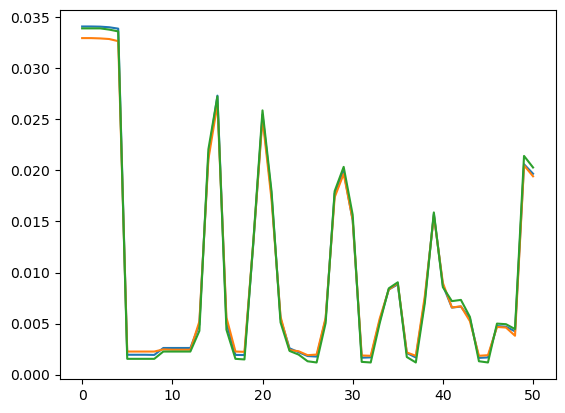

In [16]:
num_features = g.num_node_features
net = SocialGNN(num_features = num_features, f = 128)
train_social(net, g, epochs = 50, lr = 0.0001)